<a href="https://colab.research.google.com/github/Fairooz-J/Sentiment-Analysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dataset and splitting into testing and training data

In [ ]:
import numpy as np # for numerical functions
import pandas as pd # data manupulation
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # data visualisation
import plotly.express as px # data visualisation

# to split data into test, train  and validation
from sklearn.model_selection import train_test_split

# Import data cleaning packages
import string
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer


import string
from bs4 import BeautifulSoup
!pip install num2words
from num2words import num2words


# Import vectorization functions and classifiers
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle

# Import libraries for statistical analysis and visualisation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [ ]:
# I have found that downloading the dataset from kaggle to be much faster than uploading from drive
# It does however require a kaggle account
!pip install opendatasets --upgrade # username: fairoozzjalal, key:3c3c82efcc71cac040a687ccefb5ff0a
import opendatasets as od
od.download("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")


In [ ]:
# Loading dataset and viewing data
data=pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', engine='python', encoding="utf-8",on_bad_lines='warn')


# Apply LabelEncoding to make target feature into numerical (Positive : 1 , Negative : 0)
# This is to make it machine-readable
data['sentiment'].replace({'positive':1, 'negative':0}, inplace  = True)
print(data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


### EDA

In [ ]:
# display number of columns in dataset
data.shape

(50000, 2)

In [ ]:
# display types of data in dataset
data.dtypes

review       object
sentiment     int64
dtype: object

In [ ]:
# check for null values
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
# generate discriptive statistics
data.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
# print summary of dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
# print unique values
data['sentiment'].unique()

array([1, 0])

In [ ]:
# display sentiment counts to make sure all data has been read
data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


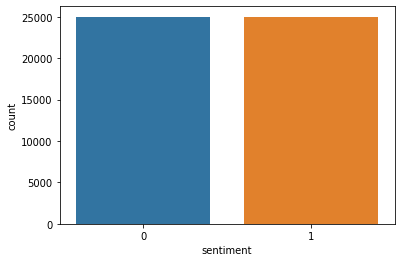

In [ ]:
# diaply graph to show even distribution of sentiments
sns.countplot(data['sentiment'])

Text(0.5, 0, 'Frequency')

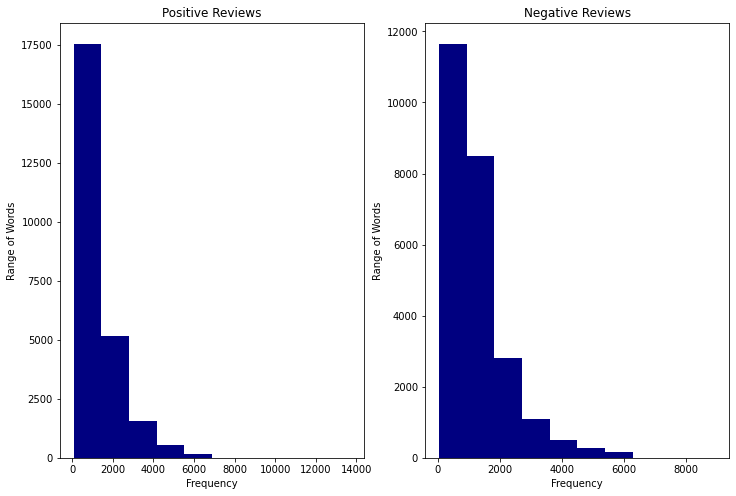

In [ ]:
# Dsipaly graph to show distribution of words in both sentiment

# Get all positive reviews
positive_reviews = data[data['sentiment']== 1]['review']
positive_reviews.head()

# Get all negative reviews
negative_reviews = data[data['sentiment']== 0]['review']
negative_reviews.head()

# Set up two subplots for both sentiments
fig,(ax_pos,ax_neg)=plt.subplots(1,2,figsize=(12,8))

# Display length of reviews for positive sentiment
ax_pos.hist(positive_reviews.str.len(), color="navy")
ax_pos.set_title( 'Positive Reviews')
ax_pos.set_ylabel("Range of Words")
ax_pos.set_xlabel("Frequency")

# Display length of reviews for negative sentiment
ax_neg.hist(negative_reviews.str.len(), color="navy")
ax_neg.set_title( 'Negative Reviews')
ax_neg.set_ylabel("Range of Words")
ax_neg.set_xlabel("Frequency")

In [ ]:

# Finding most common words
# Words that appear mostly commonly are later removed duting the preprocessing stage
# Note that '/><br' can be seen as a common occurrence and will be removed along with other HTML tags
# Another observation is the presence of high occurrence of words like 'not' which can likely be an
# emphasis on a negative review. Removal of this word may result is a less robust model
from collections import Counter
cnt = Counter()
for text in data['review'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(100)

[('the', 568735),
 ('a', 306960),
 ('and', 301919),
 ('of', 283625),
 ('to', 261850),
 ('is', 203056),
 ('in', 169981),
 ('I', 132498),
 ('that', 126818),
 ('this', 113726),
 ('it', 107916),
 ('/><br', 100974),
 ('was', 92658),
 ('as', 83130),
 ('with', 82569),
 ('for', 80919),
 ('The', 67317),
 ('but', 66282),
 ('on', 61197),
 ('movie', 60762),
 ('are', 56513),
 ('film', 54277),
 ('his', 54198),
 ('have', 54009),
 ('not', 52140),
 ('you', 50697),
 ('be', 50539),
 ('at', 42421),
 ('by', 42290),
 ('he', 42114),
 ('one', 41334),
 ('an', 41076),
 ('from', 37876),
 ('who', 37207),
 ('like', 36028),
 ('all', 35272),
 ('they', 35201),
 ('has', 32420),
 ('so', 32386),
 ('just', 32338),
 ('or', 32221),
 ('about', 32036),
 ('her', 29944),
 ('out', 28679),
 ('some', 28052),
 ('very', 25794),
 ('more', 25412),
 ('This', 24329),
 ('would', 23578),
 ('what', 23320),
 ('when', 22749),
 ('good', 22582),
 ('if', 22009),
 ('their', 21975),
 ('only', 21694),
 ('It', 21475),
 ('really', 21322),
 ('had', 

In [ ]:
# split data into training and testing evenly
training_data, testing_data = train_test_split(data, test_size=0.5, random_state=25)

print(f"No. of training data: {training_data.shape[0]}")
print(f"No. of testing data: {testing_data.shape[0]}")

No. of training data: 25000
No. of testing data: 25000


In [ ]:
training_data.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
0,12406
1,12594


In [ ]:
testing_data.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
0,12594
1,12406


# Data Cleaning

In [ ]:
# The following pre-processing will be done to the data
# Converting all text to lowercase *
# Remove HTML strips *
# Remove URLs *
# Remove noisy text *
# Remove square brackets ** removes with punctuation
# Remove special characters *
# Expand contractions *
# Filter stopwords *
# Remove Punctuation *
# Tokenization
# Stemming
# Lemmatization
# Remove frequent words (bag of words and TFI-DF)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**1. Convert Text to Lowercase**

In [ ]:
training_data.head()

,review,sentiment
45069,Garde à Vue has to be seen a number of times i...,1
46485,The concept was ok but hardly original. The ac...,0
45857,"While movie titles contains the word 'Mother',...",1
15043,Deep Blood... Its one of those movies you here...,1
25586,"(Avast, slight spoilers ahead) I got this tape...",0


In [ ]:
# Converting data to lowercase to avoid case sensitivity
training_data['review'] = training_data['review'].str.lower()
training_data.head(10)

,review,sentiment
45069,garde à vue has to be seen a number of times i...,1
46485,the concept was ok but hardly original. the ac...,0
45857,"while movie titles contains the word 'mother',...",1
15043,deep blood... its one of those movies you here...,1
25586,"(avast, slight spoilers ahead) i got this tape...",0
1063,"like the other comments says, this might be su...",0
17734,bridget fonda has disappointed me several time...,1
30996,it is a well known fact that when gene roddenb...,1
19213,no idea how this is rated as high as it is (5....,0
12079,i had always heard about this great mini-serie...,1


In [ ]:
# Remove HTML tags using regex
def remove_html(text):
    return BeautifulSoup(text, "lxml").text
training_data['review']= training_data['review'].apply(lambda text: remove_html(text))

# Remove URLs using regex
# this is most commonly http:// links
# however it is to be noted that there may be URLs with .com and no http:// that may be present
training_data['review'] = training_data['review'].str.replace('http\S+|www.\S+', '', case=False)


# Display data
with pd.option_context('display.max_colwidth', None):
  display(training_data)


<ipython-input-71-37ba6eeae22d>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  training_data['review'] = training_data['review'].str.replace('http\S+|www.\S+', '', case=False)


,review,sentiment
45069,"garde à vue has to be seen a number of times in order to understand the sub-plots it contains. if you're not used to french wordy films, based upon conversation and battle of wits rather than on action, don't even try to watch it. you'll only obtain boredom to death, and reassured opinion that french movies are not for you.garde à vue is a wordy film, essentially based upon dialogs (written by audiard by the way)and it cruelly cuts the veil of appearances.why does maître martineau (serrault) prefer to be unduly accused of being a child murderer rather than telling the truth ? because at the time of the murder he was with a 18 years old girl with which he has a 8-years sexual relation. his wife knows it, she's jealous of it and he prefers to be executed (in 1980 in france, there was still death penalty)rather than unveiling the sole ""pure and innocent"" aspect of his pitiful life.",1
46485,the concept was ok but hardly original. the acting was plastic. but the real spoiler was that there was only one joke and a grubby one at that. this is a film for fourteen year olds who have been let out on their own for the first time. don't dare to watch it with your kids.,0
45857,"while movie titles contains the word 'mother', the first thing that comes to our mind will be a mother's love for her children.however, the mother tells a different story.the mother do not discuss the love between a mother and her child, or how she sacrifice herself for the benefit of her child. here, notting hill director roger michell tells us how a mother's love for a man about half of her age hurts the people around her.before daniel craig takes on the role of james bond, here, he plays darren, a man who is helping to renovate the house of the son of the mother, and sleeping with her daughter as well. anne reid, who was a familiar face on tv series, takes up the challenging role of the leading character, may.the story begins with may coping with the sudden loss of her husband, toots, in a family visit to her son, bobby. while she befriends darren, a handyman who is doing some renovation in bobby's house, she was shocked to found out that her daughter, paula, was sleeping with darren. at the same time, may was coping with life after the death of toots. fearing that harry and paula do not wanted her, may starts to find her life going off track, until she spends her afternoon with darren.darren was nice and friendly to may, and may soon finds some affection on darren. instead of treating him like a friend, she treated the man who was about half her age with love of a couple. later, may found sexual pleasure from darren, where he gave her the pleasure she could never find on anyone else. and this is the beginning of the disaster that could lead to the break down of a family.the mother explores the inner world of a widow who wanted to try something she never had in her life, and solace on someone who is there for her to shoulder on. this can be told from may buying tea time snacks for darren to fulfilling sexual needs from a man younger than her, where it eventually gave her more than she bargained for.anne reid has made a breakthrough for her role of may, as she was previously best well known for her various role on tv series. as she do not have much movies in her career resume, the mother has put her on the critic's attention. daniel craig, on the other hand, had took on a similar role in his movie career, such as sylvia (2003) and enduring love (2004). if his reprising role of james bond fails, film reviewers should not forget that he has a better performance in small productions in his years of movie career, and the mother is one of them.the mother may not be everyone's favorite, but it is definitely not your usual matinée show to go along with tea and scones, accompanied by butter and jam.",1
15043,"deep blood... its one of those movies you here about and you say not another italian jaws ripoff! well, deep blood is far from that. it 

In [ ]:
# below are a declaration of some of the most common contractions
import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

# complie regular expression pattern into a regex pattern object
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

# look for regex pattern in string and replace if found
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

training_data["review"] = training_data["review"].apply(lambda text: expandContractions(text))


In [ ]:
# Remove punctuation

# import punctuation list from string library
Punct_List = string.punctuation

# Create a one-to-one mapping of characters in a string an removes punctuations from list
def removePunctuation(text):
  return text.translate(str.maketrans('', '', Punct_List))

training_data["review"] = training_data['review'].apply(lambda text: removePunctuation(text))
training_data.head(10)

,review,sentiment
45069,garde à vue has to be seen a number of times i...,1
46485,the concept was ok but hardly original the act...,0
45857,while movie titles contains the word mother th...,1
15043,deep blood its one of those movies you here ab...,1
25586,avast slight spoilers ahead i got this tape fr...,0
1063,like the other comments says this might be sur...,0
17734,bridget fonda has disappointed me several time...,1
30996,it is a well known fact that when gene roddenb...,1
19213,no idea how this is rated as high as it is 58 ...,0
12079,i had always heard about this great miniseries...,1


In [ ]:
# Display data
with pd.option_context('display.max_colwidth', None):
  display(training_data['review'])

45069                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
# Split Data into review and sentiment
train_x, train_y = training_data['review'], training_data['sentiment']

In [ ]:
# Downloads the NLTK corpus for tokenisation which includes a pre-trained model
nltk.download('punkt')
# Dowloads a list of commonly occurring works 
nltk.download("stopwords") 
# Accessing only english list of topwords
STOPWORDS = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
 # Removes numbers to ensure better tokenisation
train_x = train_x.str.replace('\d+', '')

# Remove stopwords
def removeStopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

train_x = train_x.apply(lambda text: removeStopwords(text))

<ipython-input-78-bbdd1a854dbb>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_x = train_x.str.replace('\d+', '')


In [ ]:
# Remove special characters using regular expression
# re.sub replaces all occurences of a patterns in a string 
# The patterns uses a negated character [^] to match any character that does not
# belong to (a-z), (A-Z), (0-0) or whitespace (\s)
def removeSpecialCharacters(text):
  text = re.sub(r'[^a-zA-z0-9\s]', '', text)
  return text

train_x = train_x.apply(removeSpecialCharacters)


In [ ]:
# Tokenization
# the lambda function is used as an argument and applies nltk.word_tokenize to each row of train_x
train_x= train_x.apply(lambda row: nltk.word_tokenize(row))

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_pos_tag(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def textLemmatization(text):
      text= ' '.join([lemmatizer.lemmatize(word, wordnet.VERB) for word in text])
      return text

#Apply function on review column
train_x=train_x.apply(textLemmatization)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Use the same function for the validation set
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
#     test_size=0.2, random_state=25)

In [ ]:
# pd.to_pickle(train_x, "./training_processed_x.pkl")
# pd.to_pickle(train_y, "./training_processed_y.pkl")
# train_x = pd.read_pickle("./training_untokenized_wo_stopwords_special_characters_w_STEM_LEMM.pkl")

In [ ]:
train_x = pd.read_pickle("./training_processed_x.pkl")
df2 = train_x.copy()

# Finding most common words
from collections import Counter
cnt = Counter()
for text in df2.values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('film', 37151),
 ('movie', 33215),
 ('one', 20039),
 ('make', 17507),
 ('like', 17223),
 ('see', 16187),
 ('get', 14100),
 ('time', 12027),
 ('good', 11161),
 ('character', 10923)]

In [ ]:
# Finding rarest words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
print(RAREWORDS)

In [ ]:
# Finding words not available in dictionary
nltk.download('wordnet')
from collections import Counter
cnt = Counter()
for text in df2.values:
    for word in text.split():
        if wordnet.synsets(word):
            break;
        else:
            cnt[word] += 1
        
cnt.most_common()

In [ ]:
# Split Data into review and sentiment
test_x, test_y = testing_data['review'], testing_data['sentiment']

# Use the same function for the validation set
# This is so the validation set can be used when the model is tuned 
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
    test_size=0.2, random_state=25)

# Since pre-processing is a long process I have decided to convert all sets into pickle files
# that can be used throughout the code
pd.to_pickle(train_x, "./training_processed_x.pkl")
pd.to_pickle(train_y, "./training_processed_y.pkl")

pd.to_pickle(test_x, "./test_x_v4.pkl")
pd.to_pickle(test_y, "./test_y_v4.pkl")

pd.to_pickle(val_x, "./val_x.pkl")
pd.to_pickle(val_y, "./val_y.pkl")


# Feature Distribution of Words

In [ ]:
train_x = pd.read_pickle("./training_processed_x.pkl")

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(test_x)

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(train_x)

In [ ]:
# Distribution of all words
df_dist = train_x.copy()
all_words = []
for i in df_dist.values:
    for w in i.split():
        all_words.append(w.lower())

all_words = nltk.FreqDist(all_words)

In [ ]:
print('The word "great" was used {} times'.format(all_words['great']))
print('The word "best" was used {} times'.format(all_words['best']))
print('The word "good" was used {} times'.format(all_words['good']))
print('The word "like" was used {} times'.format(all_words['like']))
print('The word "love" was used {} times'.format(all_words['love']))
print('The word "mediocre" was used {} times'.format(all_words['mediocre']))
print('The word "bad" was used {} times'.format(all_words['bad']))
print('The word "hate" was used {} times'.format(all_words['hate']))
print('The word "worst" was used {} times'.format(all_words['worst']))

In [ ]:
# Determine most relevant features
word_features = [item[0] for item in all_words.most_common(10000)]

In [ ]:
print('The word "{}" occurred {} times in our frequency distribution'.format(word_features[5], all_words[word_features[7]]))
print('The word "{}" occurred {} times in our frequency distribution'.format(word_features[10], all_words[word_features[23]]))
print('The word "{}" occurred {} times in our frequency distribution'.format(word_features[25], all_words[word_features[24]]))

In [ ]:
# Unigram Language Model
from collections import Counter
df_dist = train_x.copy()

count = Counter()
for text in df_dist.values:
    for word in text.split():
        count[word] += 1
        
count.most_common(10)
most_common_uni = dict(cnt.most_common(10))
most_common_df = pd.DataFrame(columns = ["Most Common Words" , 'Count'])
most_common_df["Most Common Words"] = list(most_common_uni.keys())
most_common_df["Count"] = list(most_common_uni.values())

# Plot distribution of unigram model into bar chart
fig = px.bar(most_common_df, x="Count", y="Most Common Words", title='Common Unigrams', orientation='h', 
             width=700, height=700)
fig.update_layout( yaxis={'categoryorder':'total ascending'})
fig.show()

In [ ]:
# Bigram Language Model
from sklearn.feature_extraction.text import CountVectorizer

def getCommonBigrams(text, length):
    vector = CountVectorizer(ngram_range=(2, 2)).fit(text)
    bagOfWords = vector.transform(text)
    sumOfWords = bagOfWords.sum(axis=0) 
    frequency = [(word, sumOfWords[0, idx]) for word, idx in vector.vocabulary_.items()]
    frequency =sorted(frequency, key = lambda x: x[1], reverse=True)
    return frequency[:length]

# Get top 20 bigrams
commonBigrams = getCommonBigrams(df_dist, 20)
commonBigrams = dict(commonBigrams)
common_bi_df = pd.DataFrame(columns = ["Common Bigrams" , 'Count'])
common_bi_df["Common Bigrams"] = list(commonBigrams.keys())
common_bi_df["Count"] = list(commonBigrams.values())
fig = px.bar(common_bi_df, x="Count", y="Common Bigrams", title='Common Bigrams')
fig.update_layout( yaxis={'categoryorder':'total ascending'})

fig.show()

# Training the Machine Learning Model

In [ ]:
train_x = pd.read_pickle("./training_processed_x.pkl")
train_y = pd.read_pickle("./training_processed_y.pkl")

train_x, train_y = shuffle(train_x, train_y)


In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(train_x)

In [ ]:
train_x.shape

(20000,)

In [ ]:


# Bag of Words #min_df=0,max_df=1,binary=False,ngram_range=(1,3)
#count_vect = CountVectorizer()
#cv_train_x = count_vect.fit_transform(train_x)
# TF-IDF Score max_features=5000
#tfdif_vect = TfidfVectorizer()
#tfdif_train_x = tfdif_vect.fit_transform(train_x)


### Logistic Regression using CountVectorizer

In [ ]:
# Logistic Regression using CountVectorizer

# Vector Scores
count_vect = CountVectorizer()
cv_train_x = count_vect.fit_transform(train_x)

# Train model
train_y = pd.read_pickle("./training_processed_y.pkl")
log_reg = LogisticRegression()
log_reg.fit(cv_train_x,train_y)

# Save Vectorizer
vec_file = 'vectorizer2.pickle'
pickle.dump(count_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'log_reg2.model'
pickle.dump(log_reg, open(mod_file, 'wb'))


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
log_reg.score(cv_train_x,train_y)

0.9982

### Logistic Regression using TF-IDF

In [ ]:
# Logistic Regression using TF-IDF

# Vector score
tfdif_vect = TfidfVectorizer()
tfdif_train_x = tfdif_vect.fit_transform(train_x)

# Train model
train_y = pd.read_pickle("./training_processed_y.pkl")
log_reg = LogisticRegression()
log_reg.fit(tfdif_train_x,train_y)

# Save Vectorizer
vec_file = 'vectorizer_tfidf.pickle'
pickle.dump(tfdif_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'log_reg_tfidf.model'
pickle.dump(log_reg, open(mod_file, 'wb'))

log_reg.score(tfdif_train_x,train_y)


0.9354

In [ ]:
test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")
import pickle

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_tfidf.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('log_reg_tfidf.model', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(test_x))
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,classification_report

accuracy = accuracy_score(test_y,y_pred)
print("TF-TDF Logistic Regression Acurracy :",accuracy)

f1Score= f1_score(test_y,y_pred,average=None)
print("TF-TDF Logistic Regression F1 Score :",f1Score)

conf_mat = confusion_matrix(test_y,y_pred)
print("TF-TDF Logistic Regression Confusion Matrix :",conf_mat)


TF-TDF Logistic Regression Acurracy : 0.85768
TF-TDF Logistic Regression F1 Score : [0.84802665 0.86618023]
TF-TDF Logistic Regression Confusion Matrix : [[ 9927  2667]
 [  891 11515]]


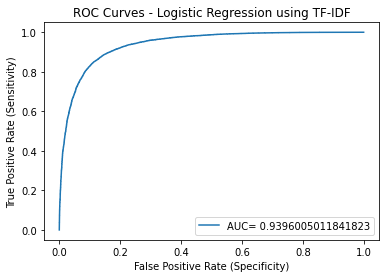

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr , thresholds= roc_curve(test_y, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba)

# Create ROC curve
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.legend(loc=4)
plt.title("ROC Curves - Logistic Regression using TF-IDF")
plt.show()

### Logistic Regression using TF-IDF and tri-grams

In [ ]:
# TF-IDF Score
tfdif_vect = TfidfVectorizer(ngram_range=(1,3))
tfdif_train_x = tfdif_vect.fit_transform(train_x)

In [ ]:
# Logistic Regression using TF-IDF

# Train model
train_y = pd.read_pickle("./training_processed_y.pkl")
log_reg = LogisticRegression()
log_reg.fit(tfdif_train_x,train_y)

# Save Vectorizer
vec_file = 'vectorizer_tfidf_2.pickle'
pickle.dump(tfdif_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'log_reg_tfidf_2.model'
pickle.dump(log_reg, open(mod_file, 'wb'))

log_reg.score(tfdif_train_x,train_y)


0.9738

### Support Vector Machine with CountVectorizer

In [ ]:
# Support Vector Machine 
# Takes about 21 minutes

#Bag of Words #min_df=0,max_df=1,binary=False,ngram_range=(1,3)
count_vect = CountVectorizer()
cv_train_x = count_vect.fit_transform(train_x)

# Train model
train_y = pd.read_pickle("./training_processed_y.pkl")
svm = SVC(kernel='linear', probability= True)
svm.fit(cv_train_x,train_y)

# Save Vectorizer
vec_file = 'vectorizer_svm.pickle'
pickle.dump(count_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'svm.model'
pickle.dump(svm, open(mod_file, 'wb'))



In [ ]:
svm.score(cv_train_x,train_y)

0.99995

### Support Vector Machine with TF-IDF

In [ ]:
# TF-IDF Score
tfdif_vect = TfidfVectorizer()
tfdif_train_x = tfdif_vect.fit_transform(train_x)

In [ ]:
# Support Vector Machine with TF-IDF 
# Very long training time of 40 mins

# Train model
train_y = pd.read_pickle("./training_processed_y.pkl")
svm = SVC(kernel='linear', probability= True)
svm.fit(tfdif_train_x,train_y)

# Save Vectorizer
vec_file = 'vectorizer_svm_tfidf.pickle'
pickle.dump(tfdif_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'svm_tfidf.model'
pickle.dump(svm, open(mod_file, 'wb'))

svm.score(tfdif_train_x,train_y)


0.9685

### Support Vector Machine with TF-IDF and n-gram models

In [ ]:
# TF-IDF Score
tfdif_vect = TfidfVectorizer(ngram_range=(1,2))
tfdif_train_x = tfdif_vect.fit_transform(train_x)

In [ ]:
# Support Vector Machine with TF-IDF 
# Took a much shorter amount of time of 11 mins 0 sec

# Train model
# train_y = pd.read_pickle("./training_processed_y.pkl")
svm = SVC(kernel='linear',probability=True)
svm.fit(tfdif_train_x,train_y)

# Save Vectorizer
vec_file = 'vectorizer_svm_tfidf_2.pickle'
pickle.dump(tfdif_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'svm_tfidf_2.model'
pickle.dump(svm, open(mod_file, 'wb'))

svm.score(tfdif_train_x,train_y)


0.99635

# Model Tuning

### SVM with Hyperparameter Tuning with just CountVectorizer

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

validate_x = pd.read_pickle("./validate_x2.pkl")
validate_y = pd.read_pickle("./validate_y2.pkl")

# with pd.option_context('display.max_colwidth', None):
#   display(validate_x)

count_vect = CountVectorizer()
cv_val_x = count_vect.fit_transform(validate_x)

# define model and parameters
svm = SVC()
# kernel = ['poly', 'rbf']
# C = [50, 10, 1.0, 0.1, 0.01]
# gamma = ['scale']

# define grid search
grid = {'C': [0.1,1, 10, 50],'kernel': ['rbf', 'poly']}
# grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=svm, param_grid = grid, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(cv_val_x, validate_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))


### SVM with Hyperparameter Tuning with TF-IDF

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

validate_x = pd.read_pickle("./validate_x2.pkl")
validate_y = pd.read_pickle("./validate_y2.pkl")

# with pd.option_context('display.max_colwidth', None):
#   display(validate_x)

tfdif_vect = TfidfVectorizer()
tfdif_val_x = tfdif_vect.fit_transform(validate_x)

# define model and parameters
svm = SVC()
# kernel = ['poly', 'rbf']
# C = [50, 10, 1.0, 0.1, 0.01]
# gamma = ['scale']

# define grid search
grid = {'C': [0.1,1, 10, 50],'kernel': ['rbf', 'poly','linear']}
# grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=svm, param_grid = grid, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(tfdif_val_x, validate_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))


### Testing Tuned Model BoW

In [ ]:
# Support Vector Machine 
# Best score and parameters: 0.836533 using {'C': 10, 'kernel': 'rbf'}
# 1hr 22mins

#Bag of Words
count_vect = CountVectorizer()
cv_train_x = count_vect.fit_transform(train_x_shuffle)

# Train model
svm = SVC( C= 10, kernel='rbf', probability= True)
svm.fit(cv_train_x,train_y_shuffle)

# Save Vectorizer
vec_file = 'vectorizer_svm_tuned_2.pickle'
pickle.dump(count_vect, open(vec_file, 'wb'))

# Save Model
mod_file = 'svm_tuned_2.model'
pickle.dump(svm, open(mod_file, 'wb'))



In [ ]:
svm.score(cv_train_x,train_y)

0.99915

In [ ]:
# using data shuffling
svm.score(cv_train_x,train_y_shuffle)

0.99915

# Results & Evaluation

In [ ]:
import pickle

test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")

### Logistic Regression Count Vectoriser Results

In [ ]:

#load the model
loaded_model = pickle.load(open('log_reg2.model', 'rb'))

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer2.pickle', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(test_x))
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]

accuracy = accuracy_score(test_y,y_pred)
print("BOW Logistic Regression Acurracy :",accuracy)

f1Score= f1_score(test_y,y_pred,average=None)
print("BOW Logistic Regression F1 Score :",f1Score)

conf_mat = confusion_matrix(test_y,y_pred)
print("BOW Logistic Regression Confusion Matrix :",conf_mat)


BOW Logistic Regression Acurracy : 0.84832
BOW Logistic Regression F1 Score : [0.85235945 0.8440533 ]
BOW Logistic Regression Confusion Matrix : [[10946  1648]
 [ 2144 10262]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85     12594
           1       0.86      0.83      0.84     12406

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



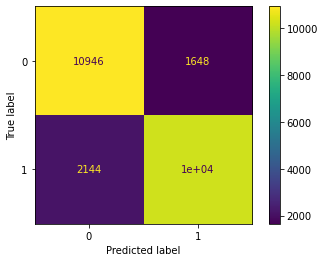

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

cm = confusion_matrix(test_y, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

[Text(0.5, 1.0, 'Confusion Matrix - Log Res BoW')]

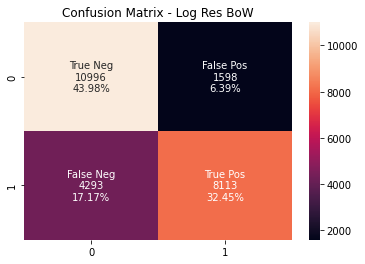

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='').set(title='Confusion Matrix - Log Res BoW')

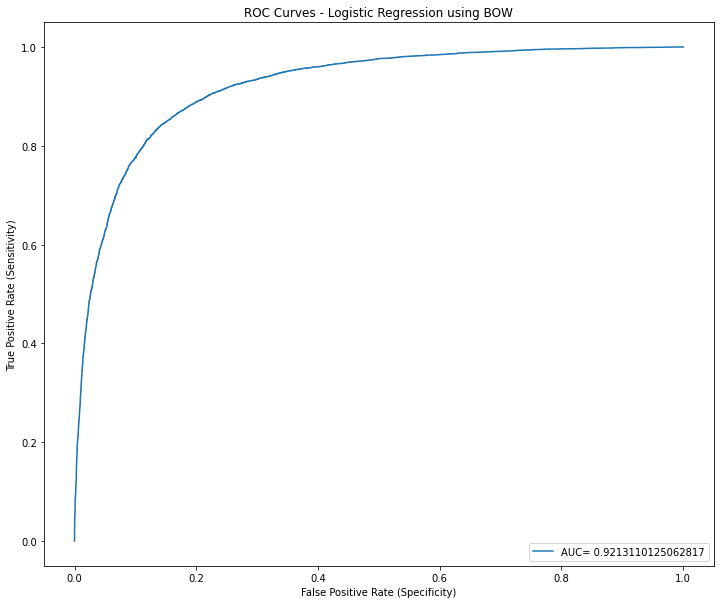

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(test_y,y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba)

# Create Receiver Operating Characteristic curve
plt.figure(figsize = (12,10))
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.title("ROC Curves - Logistic Regression using BOW")
plt.legend(loc=4)
plt.show()

### Logistic Regression TF-IDF Trigram Results

In [ ]:
import pickle
test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_tfidf_2.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('log_reg_tfidf_2.model', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(test_x))

In [ ]:
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]

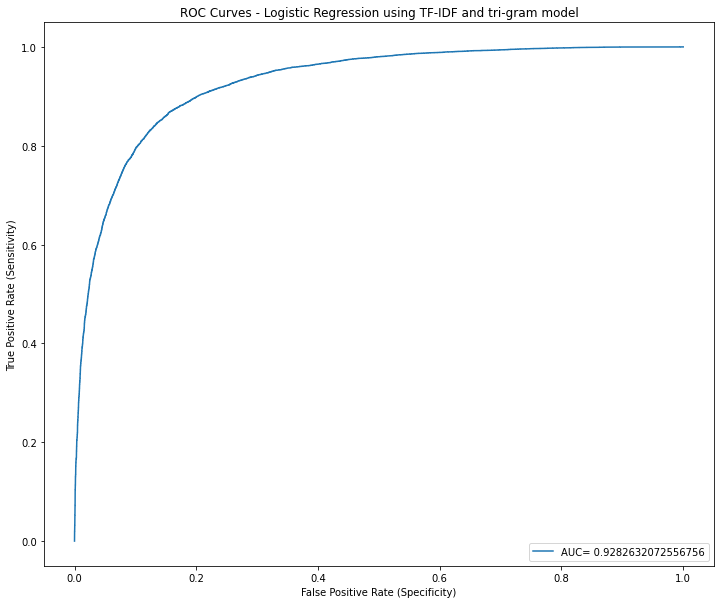

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr , thresholds= roc_curve(test_y, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba)

# Create ROC curve
plt.figure(figsize = (12,10))
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.legend(loc=4)
plt.title("ROC Curves - Logistic Regression using TF-IDF and tri-gram model")
plt.show()

In [ ]:
print(y_proba)

[[0.3614385  0.6385615 ]
 [0.4010523  0.5989477 ]
 [0.39629282 0.60370718]
 ...
 [0.8076969  0.1923031 ]
 [0.32418641 0.67581359]
 [0.4679525  0.5320475 ]]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,classification_report

accuracy = accuracy_score(test_y,y_pred)
print("TF-TDF Logistic Regression Acurracy :",accuracy)

f1Score= f1_score(test_y,y_pred,average=None)
print("TF-TDF Logistic Regression F1 Score :",f1Score)

conf_mat = confusion_matrix(test_y,y_pred)
print("TF-TDF Logistic Regression Confusion Matrix :",conf_mat)


TF-TDF Logistic Regression Acurracy : 0.8336
TF-TDF Logistic Regression F1 Score : [0.81832474 0.84650579]
TF-TDF Logistic Regression Confusion Matrix : [[ 9369  3225]
 [  935 11471]]


### SVM Results with CountVectorizer

In [ ]:
import pickle

test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_svm.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('svm.model', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(test_x))
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,classification_report

accuracy = accuracy_score(test_y,y_pred)
print("BOW SVM Acurracy :",accuracy)

f1Score= f1_score(test_y,y_pred,average=None)
print("BOW SVM F1 Score :",f1Score)

conf_mat = confusion_matrix(test_y,y_pred)
print("BOW SVM Confusion Matrix :",conf_mat)


BOW SVM Acurracy : 0.76436
BOW SVM F1 Score : [0.78872431 0.7336438 ]
BOW SVM Confusion Matrix : [[10996  1598]
 [ 4293  8113]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79     12594
           1       0.84      0.65      0.73     12406

    accuracy                           0.76     25000
   macro avg       0.78      0.76      0.76     25000
weighted avg       0.78      0.76      0.76     25000



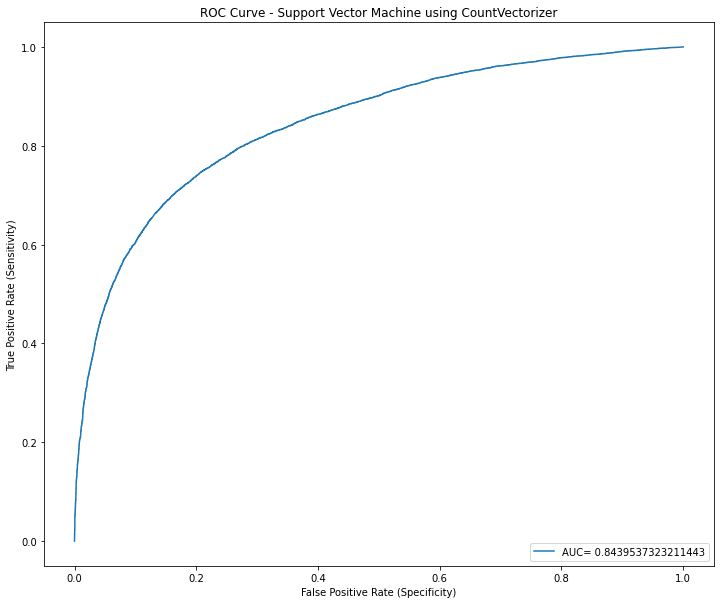

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(test_y, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba)

# Creat ROC curve
plt.figure(figsize = (12,10))
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.title("ROC Curve - Support Vector Machine using CountVectorizer")
plt.legend(loc=4)
plt.show()

[Text(0.5, 1.0, 'Confusion Matrix - SVM BoW')]

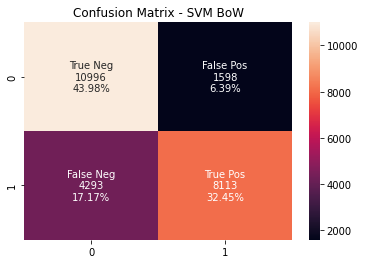

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

cm = confusion_matrix(test_y, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='').set(title='Confusion Matrix - SVM BoW')

### SVM Results with TF-IDF

In [ ]:
import pickle

test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_svm_tfidf.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('svm_tfidf.model', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(test_x))

In [ ]:
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,classification_report

accuracy = accuracy_score(test_y,y_pred)
print("TF-IDF SVM Acurracy :",accuracy)

f1Score= f1_score(test_y,y_pred,average=None)
print("TF-IDF SVM F1 Score :",f1Score)

conf_mat = confusion_matrix(test_y,y_pred)
print("TF-IDF SVM Confusion Matrix :",conf_mat)


TF-IDF SVM Acurracy : 0.86088
TF-IDF SVM F1 Score : [0.86052294 0.86123524]
TF-IDF SVM Confusion Matrix : [[10729  1865]
 [ 1613 10793]]


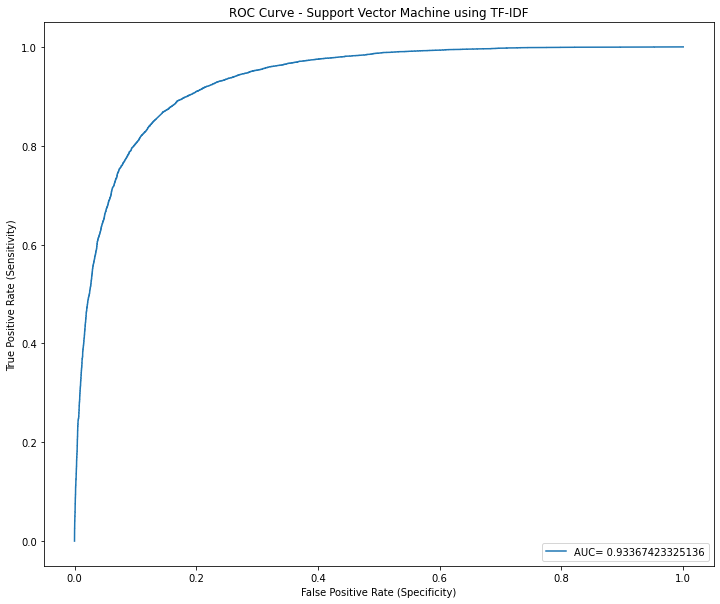

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(test_y, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba)

# Create Receiver Operating Characteristic curve
plt.figure(figsize = (12,10))
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.title("ROC Curve - Support Vector Machine using TF-IDF")
plt.legend(loc=4)
plt.show()

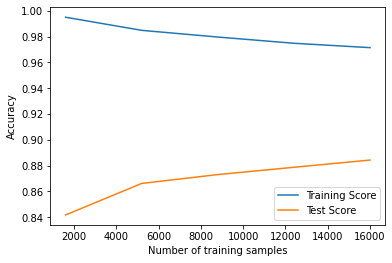

In [ ]:
# Learning curve unexpectedly shows a straight line which could mean that the model is overfitting
# Future work could focus on improvements such as training with more samples, 
# reducing more irrelevant features


from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(loaded_model, tfdif_train_x, train_y, cv=5, scoring="accuracy" )

plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Test Score")
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

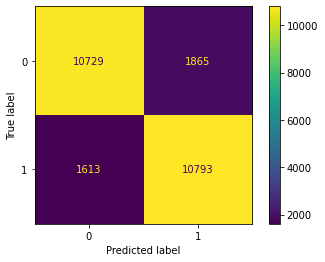

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

cm = confusion_matrix(test_y, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

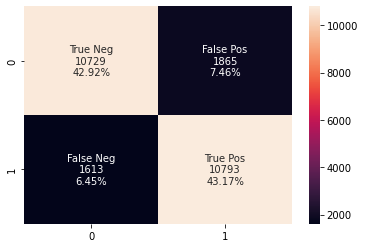

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12594
           1       0.85      0.87      0.86     12406

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [ ]:
from sklearn.metrics import precision_recall_curve, auc

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(test_y, y_proba)

#create precision recall curve and area under curve
plt.figure(figsize = (12,8))
auc_precision_recall = auc(recall, precision)
plt.plot(recall, precision, color='navy',label="AUC= "+str(auc_precision_recall))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title("Precision-Recall Curve SVM using TF-IDF")

#display plot
plt.legend()
plt.show()

### SVM Results with Bi-gram model

In [ ]:
import pickle

val_x = pd.read_pickle("./validate_x2.pkl")
val_y = pd.read_pickle("./validate_y2.pkl")

val_x, val_y = shuffle(val_x, val_y)


# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_svm_tfidf_2.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('svm_tfidf_2.model', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(val_x))
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(val_x))[:,1]

In [ ]:
print(classification_report(val_y,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2536
           1       0.88      0.91      0.90      2464

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



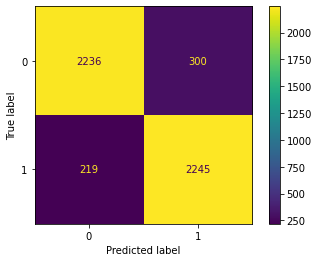

In [ ]:
cm = confusion_matrix(val_y, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

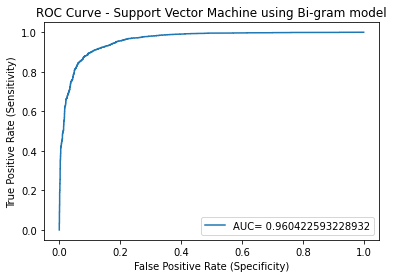

In [ ]:
fpr, tpr, _ = roc_curve(val_y, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(val_y, y_proba)

# Creat ROC curve
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.title("ROC Curve - Support Vector Machine using Bi-gram model")
plt.legend(loc=4)
plt.show()

In [ ]:
import pickle

test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_svm_tfidf_2.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('svm_tfidf_2.model', 'rb'))

# make a prediction
y_pred_test = loaded_model.predict(loaded_vectorizer.transform(test_x))
y_proba_test = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]

In [ ]:
print(classification_report(test_y,y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     12594
           1       0.84      0.91      0.88     12406

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [ ]:
accuracy = accuracy_score(test_y,y_pred_test)
print("TF-IDF Bi-gram SVM Acurracy :",accuracy)

TF-IDF Bi-gram SVM Acurracy : 0.872


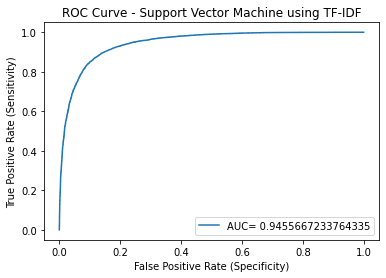

In [ ]:
fpr, tpr, _ = roc_curve(test_y, y_proba_test)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba_test)

# Creat ROC curve
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.title("ROC Curve - Support Vector Machine using TF-IDF Bi-gram model")
plt.legend(loc=4)
plt.show()

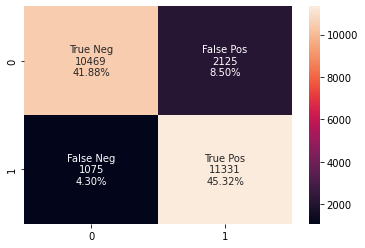

In [ ]:
cm = confusion_matrix(test_y, y_pred_test)

# cm_display = ConfusionMatrixDisplay(cm).plot()

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='')

# Tuned SVM with Bag-Of-words

In [ ]:
import pickle

test_x = pd.read_pickle("./test_x_v4.pkl")
test_y = pd.read_pickle("./test_y_v4.pkl")

# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_svm_tuned.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('svm_tuned.model', 'rb'))

# make a prediction
y_pred = loaded_model.predict(loaded_vectorizer.transform(test_x))
y_proba = loaded_model.predict_proba(loaded_vectorizer.transform(test_x))[:,1]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,classification_report

accuracy = accuracy_score(test_y,y_pred)
print("TF-IDF SVM Acurracy :",accuracy)

f1Score= f1_score(test_y,y_pred,average=None)
print("TF-IDF SVM F1 Score :",f1Score)

conf_mat = confusion_matrix(test_y,y_pred)
print("TF-IDF SVM Confusion Matrix :",conf_mat)


TF-IDF SVM Acurracy : 0.759
TF-IDF SVM F1 Score : [0.70917604 0.79424922]
TF-IDF SVM Confusion Matrix : [[ 7346  5248]
 [  777 11629]]


In [ ]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.58      0.71     12594
           1       0.69      0.94      0.79     12406

    accuracy                           0.76     25000
   macro avg       0.80      0.76      0.75     25000
weighted avg       0.80      0.76      0.75     25000



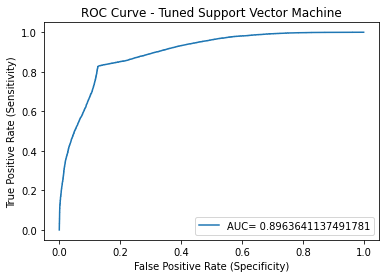

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(test_y, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
auc = roc_auc_score(test_y, y_proba)

# Creat ROC curve
plt.plot(fpr,tpr,label="AUC= "+str(auc))
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.title("ROC Curve - Tuned Support Vector Machine")
plt.legend(loc=4)
plt.show()

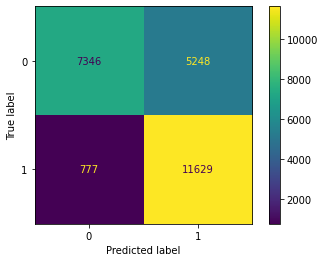

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

cm = confusion_matrix(test_y, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

# Test Model on User Input

In [ ]:
# load the vectorizer
loaded_vectorizer = pickle.load(open('vectorizer_svm_tfidf.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('svm_tfidf.model', 'rb'))

def test_model(sentence):
    vec_sen = loaded_vectorizer.transform([sentence]).toarray()
    res = loaded_model.predict(vec_sen)[0]
    return res

bad_review = 'This movie was a letdown. The plot was predictable, the acting was stiff, and the special effects were underwhelming. Overall, a disappointing waste of time.'
good_review = 'This movie was a triumph. The storyline was engaging, the acting was top-notch, and the special effects were stunning. A must-watch for any film enthusiast.'
res = test_model(bad_review)
print(res)

0
